In [1]:
import pandas as pd
reviews_df = pd.read_csv("en_reviews.csv")
reviews_df.head()

,confidence,is_good,evaluation,text
0,4.0,1,1,- The article addresses a contingent and very ...
1,4.0,1,1,The article presents practical recommendations...
2,5.0,1,1,- The theme is very interesting and a guide ca...
3,4.0,1,2,An experience of use of ICT for academic colla...
4,4.0,1,2,NaN


In [2]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)


In [3]:

# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["text"].apply(lambda x: clean_text(x))
reviews_df.head()

,confidence,is_good,evaluation,text,review_clean
271,3.0,0,-2,"The Paper has sections introduction, theoretic...",paper section introduction theoretical analysi...
46,4.0,1,0,The issue of the article is novel and necessar...,issue article novel necessary process model li...
167,4.0,1,2,"The work ""Leadership In Ti Adoption in SMEs On...",work leadership ti adoption smes owner's invol...
42,4.0,0,-1,The development of a prototype is presented fo...,development prototype present automatic alloca...
349,3.0,1,0,This article describes the results of simulati...,article describe result simulation protein fol...


In [4]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["text"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)


In [5]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["text"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["text"].apply(lambda x: len(x.split(" ")))

In [6]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)
reviews_df.head()

c:\users\clasa215b_nt17\appdata\local\programs\python\python37\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


,confidence,is_good,evaluation,text,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
271,3.0,0,-2,"The Paper has sections introduction, theoretic...",paper section introduction theoretical analysi...,0.016,0.854,0.130,0.9656,1042,154,-0.138015,-0.241226,-0.059623,-1.102301,-0.347366
46,4.0,1,0,The issue of the article is novel and necessar...,issue article novel necessary process model li...,0.066,0.865,0.069,0.1022,810,123,-0.057231,-0.106077,-0.040991,-0.792680,-0.269590
167,4.0,1,2,"The work ""Leadership In Ti Adoption in SMEs On...",work leadership ti adoption smes owner's invol...,0.042,0.819,0.138,0.9711,1311,221,-0.096069,-0.119081,0.039567,-1.135981,-0.459724
42,4.0,0,-1,The development of a prototype is presented fo...,development prototype present automatic alloca...,0.071,0.894,0.034,-0.5689,1069,172,-0.167286,-0.204012,-0.023466,-0.838826,-0.187303
349,3.0,1,0,This article describes the results of simulati...,article describe result simulation protein fol...,0.091,0.888,0.021,-0.7964,768,114,-0.118912,-0.111723,0.020182,-0.853036,-0.302836


In [7]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [8]:
reviews_df.head()


,confidence,is_good,evaluation,text,review_clean,neg,neu,pos,compound,nb_chars,...,word_problem,word_process,word_reference,word_result,word_show,word_study,word_the,word_use,word_well,word_work
271,3.0,0,-2,"The Paper has sections introduction, theoretic...",paper section introduction theoretical analysi...,0.016,0.854,0.130,0.9656,1042,...,0.000000,0.196987,0.000000,0.916048,0.000000,0.196987,0.000000,0.000000,0.00000,0.155915
46,4.0,1,0,The issue of the article is novel and necessar...,issue article novel necessary process model li...,0.066,0.865,0.069,0.1022,810,...,0.000000,0.407444,0.000000,0.189473,0.211765,0.203722,0.611165,0.156504,0.00000,0.161245
167,4.0,1,2,"The work ""Leadership In Ti Adoption in SMEs On...",work leadership ti adoption smes owner's invol...,0.042,0.819,0.138,0.9711,1311,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.503833,0.000000,0.580585,0.00000,0.598174
42,4.0,0,-1,The development of a prototype is presented fo...,development prototype present automatic alloca...,0.071,0.894,0.034,-0.5689,1069,...,0.000000,0.435198,0.419393,0.000000,0.000000,0.217599,0.000000,0.334330,0.22619,0.000000
349,3.0,1,0,This article describes the results of simulati...,article describe result simulation protein fol...,0.091,0.888,0.021,-0.7964,768,...,0.547126,0.000000,0.000000,0.352024,0.000000,0.000000,0.189248,0.290771,0.19672,0.149790


In [9]:
reviews_df["is_good"].value_counts(normalize = True)


1    0.641026
0    0.358974
Name: is_good, dtype: float64

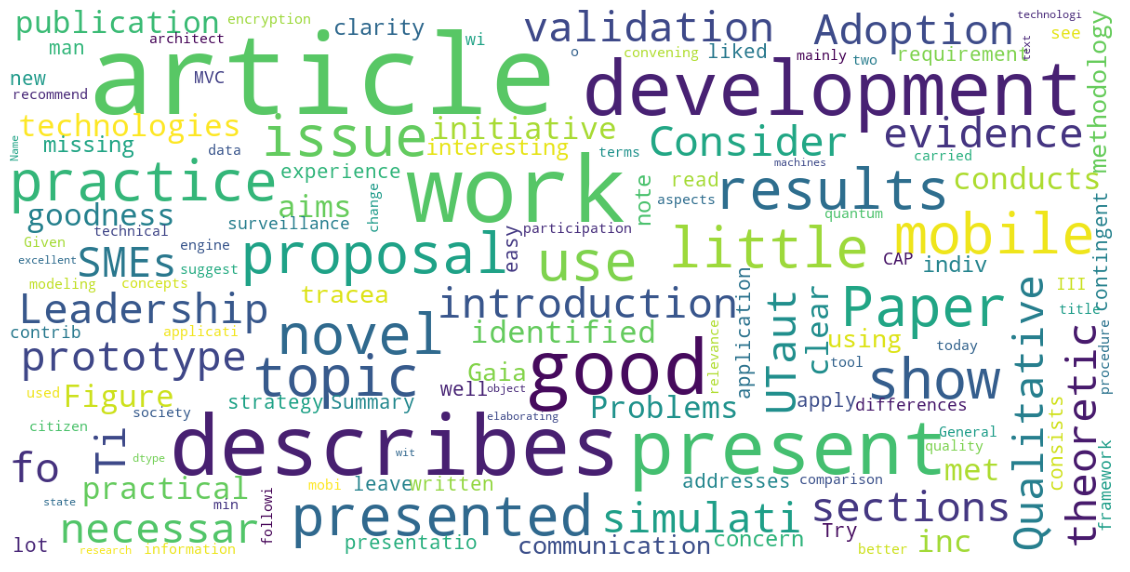

In [10]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["text"])

In [11]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["text", "pos"]].head(10)

,text,pos
9,A novel quantum encryption modeling is carried...,0.346
84,I liked it a lot I would leave it as it.,0.280
25,Good practice for better quality in the engine...,0.230
0,- The article addresses a contingent and very ...,0.219
167,"The work ""Leadership In Ti Adoption in SMEs On...",0.138
218,Summary: This work describes an experience of ...,0.132
271,"The Paper has sections introduction, theoretic...",0.130
284,"In practice, it conducts a communication using...",0.118
342,The article presents the development of a mobi...,0.116
33,Consider the use of mobile technologies to inc...,0.110


In [12]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["text", "neg"]].head(10)

,text,neg
84,I liked it a lot I would leave it as it.,0.120
33,Consider the use of mobile technologies to inc...,0.104
376,Problems identified: - Figure 7 is not clear i...,0.099
349,This article describes the results of simulati...,0.091
342,The article presents the development of a mobi...,0.090
386,A procedure for elaborating state machines wit...,0.083
82,It is an excellent research work of technologi...,0.075
42,The development of a prototype is presented fo...,0.071
384,The paper is well written and easy to read.It ...,0.069
15,Try to apply a new strategy to requirement man...,0.069


c:\users\clasa215b_nt17\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\clasa215b_nt17\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


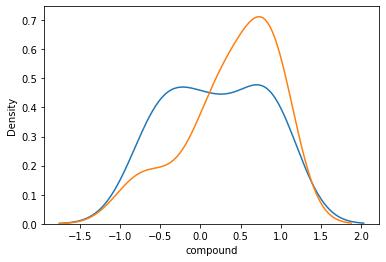

In [13]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_good'] == x]
    
    # Draw the density plot
    if x == 1:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [14]:
# feature selection
label = "is_good"
ignore_cols = [label, "text", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [15]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
1,evaluation,0.340328
20,word_present,0.048141
19,word_make,0.043636
30,word_work,0.043106
11,doc2vec_vector_3,0.039309
3,neu,0.036352
8,doc2vec_vector_0,0.036095
4,pos,0.035376
6,nb_chars,0.034933
12,doc2vec_vector_4,0.033978
